In [1]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [6]:
class ImageTransform():
    """
    화상 전처리 클래스. 훈련 시 검증 시의 동작이 다르다,.
    화상 크기를 리사이즈하고 색상을 표준화한다.
    훈련 시에는 RandomResizedCop과 RandimHorizontalFlip으로 데이터를 확장한다.


    Attributes
    ----------
    resize : int
        리사이즈 대상 화상의 크기
    mean : (R, G, B)
        각 색상 채널의 평균값
    std : (R, G, B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

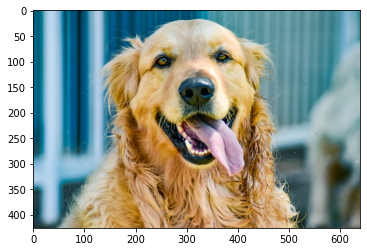

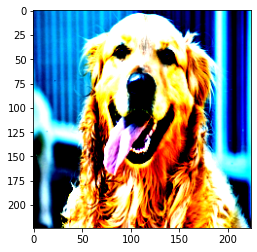

In [10]:
# 훈련 시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀜

# 1. 화상 읽기
image_file_path = 'data/goldenretriever-3724972_640.jpeg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [11]:
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트 작성

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터 지정

    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/998118368_6ac1d91f81.jpg',
 './data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train/ants/Ant_1.jpg',
 './data/hymenoptera_data/train/ants/9715481_b3cb4114ff.jpg',
 './data/hymenoptera_data/train/ants/45472593_bfd624f8dc.jpg',
 './data/hymenoptera_data/train/ants/Nepenthes_rafflesiana_ant.jpg',
 './data/hymenoptera_data/train/ants/6240338_93729615ec.jpg',
 './data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train/ants/5650366_e22b7e1065.jpg',
 './data/hymenoptera_data/train/ants/255434217_1b2b3fe0a4.jpg',
 './data/hymenoptera_data/train/ants/403746349_71384f5b58.jpg',
 './data/hymenoptera_data/train/ants/450057712_771b3bfc91.jpg',
 './data/hymenoptera_data/train/ants/20935278_9190345f6b.jpg',
 './data/hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train/ants/535522953_308353a07c.jpg',
 './data/hymenoptera_data/train/ants/175998972.jpg',
 '.

In [ ]:
class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 화상의 Dataset 클래스. 파이토치의 Dataset 클래스 상속

    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'val'
        학습인지 훈련인지 설정
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스
        self.phase = phase  # train or val 지정

    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식의 데이터와 라벨 획득
        '''

        # index번째 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭][RGB색]

        # 화상의 전처리 실시
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 화상 라벨을 파일 이름에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자로 변경
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])